In [1]:
import numpy as np
import pandas as pd
import re

# Plotting and Metrics imports
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, accuracy_score

# Data Processing imports
from sklearn.model_selection import train_test_split
import re, nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
# nltk.download('stopwords')
# nltk.download('wordnet')

# Feature Extraction imports
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier

# Doc2Vec imports
import gensim
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize

# Models imports
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

## LIAR dataset

In [2]:
# Load and Review the LIAR dataset

liar_train = pd.read_csv('02liar/train.tsv', delimiter='\t', header=None)
liar_test = pd.read_csv('02liar/test.tsv', delimiter='\t', header=None)
liar_valid = pd.read_csv('02liar/valid.tsv', delimiter='\t', header=None)

print(liar_train.head())


           0            1                                                  2   \
0   2635.json        false  Says the Annies List political group supports ...   
1  10540.json    half-true  When did the decline of coal start? It started...   
2    324.json  mostly-true  Hillary Clinton agrees with John McCain "by vo...   
3   1123.json        false  Health care reform legislation is likely to ma...   
4   9028.json    half-true  The economic turnaround started at the end of ...   

                                   3               4                     5   \
0                            abortion    dwayne-bohac  State representative   
1  energy,history,job-accomplishments  scott-surovell        State delegate   
2                      foreign-policy    barack-obama             President   
3                         health-care    blog-posting                   NaN   
4                        economy,jobs   charlie-crist                   NaN   

         6           7     8     9    

In [3]:
# Name the columns for ease of use
column_names = [
    "ID", "Label", "Statement", "Subject", "Speaker", "Speaker's Job Title", 
    "State", "Party Affiliation", "Total Credits", "Barely True Counts", 
    "False Counts", "Half True Counts", "Mostly True Counts", "Pants on Fire Counts"
]

liar_train.columns = column_names
liar_test.columns = column_names
liar_valid.columns = column_names

# Display the first few rows to verify
print(liar_train.head())


           ID        Label                                          Statement  \
0   2635.json        false  Says the Annies List political group supports ...   
1  10540.json    half-true  When did the decline of coal start? It started...   
2    324.json  mostly-true  Hillary Clinton agrees with John McCain "by vo...   
3   1123.json        false  Health care reform legislation is likely to ma...   
4   9028.json    half-true  The economic turnaround started at the end of ...   

                              Subject         Speaker   Speaker's Job Title  \
0                            abortion    dwayne-bohac  State representative   
1  energy,history,job-accomplishments  scott-surovell        State delegate   
2                      foreign-policy    barack-obama             President   
3                         health-care    blog-posting                   NaN   
4                        economy,jobs   charlie-crist                   NaN   

      State Party Affiliation  Total C

#### Study the dataset

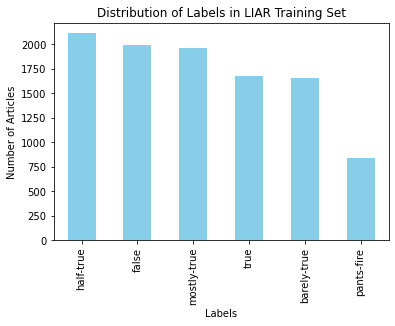

In [4]:
# Distribution

# Plotting the distribution of labels in the training set
liar_train['Label'].value_counts().plot(kind='bar', color='skyblue')
plt.title('Distribution of Labels in LIAR Training Set')
plt.xlabel('Labels')
plt.ylabel('Number of Articles')
plt.show()

In [5]:
# Missing value

# Display the number of missing values for each column in the training set
missing_values = liar_train.isnull().sum()
print("Missing values Training Set:")
print(missing_values)


Missing values Training Set:
ID                         0
Label                      0
Statement                  0
Subject                    2
Speaker                    2
Speaker's Job Title     2897
State                   2208
Party Affiliation          2
Total Credits              2
Barely True Counts         2
False Counts               2
Half True Counts           2
Mostly True Counts         2
Pants on Fire Counts     102
dtype: int64


### Data Preprocessing

In [6]:
# Data Preprocessing

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def normalize_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove special characters and digits
    text = re.sub(r'[^a-zA-Z\s]', '', text, re.I | re.A)
    # Remove stopwords and lemmatize
    text = ' '.join(lemmatizer.lemmatize(token) for token in text.split() if token not in stop_words)
    return text

liar_train['Statement'] = liar_train['Statement'].apply(normalize_text)
liar_test['Statement'] = liar_test['Statement'].apply(normalize_text)
liar_valid['Statement'] = liar_valid['Statement'].apply(normalize_text)

def map_labels(label):
    true_labels = ["true", "mostly-true", "half-true"]
    return "true" if label in true_labels else "fake"

liar_train['Label'] = liar_train['Label'].apply(map_labels)
liar_test['Label'] = liar_test['Label'].apply(map_labels)
liar_valid['Label'] = liar_valid['Label'].apply(map_labels)

print(liar_train.head())

           ID Label                                          Statement  \
0   2635.json  fake  say annies list political group support thirdt...   
1  10540.json  true  decline coal start started natural gas took st...   
2    324.json  true  hillary clinton agrees john mccain voting give...   
3   1123.json  fake  health care reform legislation likely mandate ...   
4   9028.json  true               economic turnaround started end term   

                              Subject         Speaker   Speaker's Job Title  \
0                            abortion    dwayne-bohac  State representative   
1  energy,history,job-accomplishments  scott-surovell        State delegate   
2                      foreign-policy    barack-obama             President   
3                         health-care    blog-posting                   NaN   
4                        economy,jobs   charlie-crist                   NaN   

      State Party Affiliation  Total Credits  Barely True Counts  \
0     Texas 

In [7]:
columns_to_drop = ['ID', 'Subject', 'Speaker', "Speaker's Job Title", 'State', 
                   'Party Affiliation', 'Total Credits', 'Barely True Counts', 
                   'False Counts', 'Half True Counts', 'Mostly True Counts', 
                   'Pants on Fire Counts']

liar_train.drop(columns=columns_to_drop, inplace=True)
liar_test.drop(columns=columns_to_drop, inplace=True)
liar_valid.drop(columns=columns_to_drop, inplace=True)


In [8]:
print(liar_train.columns)

Index(['Label', 'Statement'], dtype='object')


In [9]:
print(liar_valid.head())

  Label                                          Statement
0  fake                                le american working
1  fake  obama sworn office use holy bible instead kura...
2  fake  say organization parading social welfare organ...
3  true                  say nearly half oregon child poor
4  true  attack republican various program economic sti...


In [10]:
# BoW

# Initialize the CountVectorizer
vectorizer = CountVectorizer(stop_words='english', max_features=5000)  # Limiting to 5000 most frequent words for simplicity

# Fit and transform the training data from LIAR dataset
X_train_bow = vectorizer.fit_transform(liar_train['Statement'])

# Transform the validation and test data
X_valid_bow = vectorizer.transform(liar_valid['Statement'])
X_test_bow = vectorizer.transform(liar_test['Statement'])

# Print some information
print(f"Shape of BoW training data: {X_train_bow.shape}")
print(f"Shape of BoW validation data: {X_valid_bow.shape}")
print(f"Shape of BoW test data: {X_test_bow.shape}")

y_train = liar_train['Label']
y_valid = liar_valid['Label']
y_test = liar_test['Label']


Shape of BoW training data: (10240, 5000)
Shape of BoW validation data: (1284, 5000)
Shape of BoW test data: (1267, 5000)


In [11]:
# BoW + Decision Tree

# Initialize the Decision Tree Classifier
clf_tree = DecisionTreeClassifier()

# Train the classifier using the training data
clf_tree.fit(X_train_bow, y_train)

# Predict on the validation set
y_pred_tree = clf_tree.predict(X_valid_bow)

# Evaluate the performance
accuracy_tree = accuracy_score(y_valid, y_pred_tree)
print(f"Validation Accuracy: {accuracy_tree * 100:.2f}%\n")
print("Classification Report:")
print(classification_report(y_valid, y_pred_tree))


Validation Accuracy: 57.17%

Classification Report:
              precision    recall  f1-score   support

        fake       0.57      0.46      0.51       616
        true       0.58      0.67      0.62       668

    accuracy                           0.57      1284
   macro avg       0.57      0.57      0.56      1284
weighted avg       0.57      0.57      0.57      1284



In [12]:
# BoW + Random Froest

# Initialize the Random Forest Classifier
clf_rf = RandomForestClassifier()

# Train the classifier using the training data
clf_rf.fit(X_train_bow, y_train)

# Predict on the validation set
y_pred_rf = clf_rf.predict(X_valid_bow)

# Evaluate the performance
accuracy_rf = accuracy_score(y_valid, y_pred_rf)
print(f"Validation Accuracy: {accuracy_rf * 100:.2f}%\n")
print("Classification Report:")
print(classification_report(y_valid, y_pred_rf))


Validation Accuracy: 61.37%

Classification Report:
              precision    recall  f1-score   support

        fake       0.63      0.48      0.54       616
        true       0.61      0.74      0.67       668

    accuracy                           0.61      1284
   macro avg       0.62      0.61      0.60      1284
weighted avg       0.62      0.61      0.61      1284



In [13]:
#BoW + SVM

# Initialize the SVM Classifier
clf_svm_bow = SVC(kernel='linear', probability=True)

# Train the classifier using the BoW training data
clf_svm_bow.fit(X_train_bow, y_train)

# Predict on the validation set
y_pred_svm_bow = clf_svm_bow.predict(X_valid_bow)

# Evaluate the performance
accuracy_svm_bow = accuracy_score(y_valid, y_pred_svm_bow)
print(f"Validation Accuracy for SVM with BoW: {accuracy_svm_bow * 100:.2f}%\n")
print("Classification Report for SVM with BoW:")
print(classification_report(y_valid, y_pred_svm_bow))


Validation Accuracy for SVM with BoW: 56.70%

Classification Report for SVM with BoW:
              precision    recall  f1-score   support

        fake       0.56      0.49      0.52       616
        true       0.58      0.64      0.61       668

    accuracy                           0.57      1284
   macro avg       0.57      0.56      0.56      1284
weighted avg       0.57      0.57      0.56      1284



In [14]:
#BoW + KNN neighbours 5

# Initialize the KNN Classifier
clf_knn_bow = KNeighborsClassifier(n_neighbors=5)  # You can tune the 'n_neighbors' parameter

# Train the classifier using the BoW training data
clf_knn_bow.fit(X_train_bow, y_train)

# Predict on the validation set
y_pred_knn_bow = clf_knn_bow.predict(X_valid_bow)

# Evaluate the performance
accuracy_knn_bow = accuracy_score(y_valid, y_pred_knn_bow)
print(f"Validation Accuracy for KNN with BoW: {accuracy_knn_bow * 100:.2f}%\n")
print("Classification Report for KNN with BoW:")
print(classification_report(y_valid, y_pred_knn_bow))


Validation Accuracy for KNN with BoW: 53.89%

Classification Report for KNN with BoW:
              precision    recall  f1-score   support

        fake       0.52      0.42      0.46       616
        true       0.55      0.65      0.60       668

    accuracy                           0.54      1284
   macro avg       0.54      0.53      0.53      1284
weighted avg       0.54      0.54      0.53      1284



In [15]:
# TF-IDF

# Initialize the TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=5000, stop_words='english', ngram_range=(1,2))

# Fit and transform the training data
X_train_tfidf = tfidf_vectorizer.fit_transform(liar_train['Statement'])

# Transform the validation data
X_valid_tfidf = tfidf_vectorizer.transform(liar_valid['Statement'])


In [16]:
# TF-IDF + Decision Tree

# Initialize the Decision Tree Classifier
clf_tree_tfidf = DecisionTreeClassifier()

# Train the classifier using the training data
clf_tree_tfidf.fit(X_train_tfidf, y_train)

# Predict on the validation set
y_pred_tree_tfidf = clf_tree_tfidf.predict(X_valid_tfidf)

# Evaluate the performance
accuracy_tree_tfidf = accuracy_score(y_valid, y_pred_tree_tfidf)
print(f"Validation Accuracy: {accuracy_tree_tfidf * 100:.2f}%\n")
print("Classification Report:")
print(classification_report(y_valid, y_pred_tree_tfidf))


Validation Accuracy: 57.24%

Classification Report:
              precision    recall  f1-score   support

        fake       0.56      0.50      0.53       616
        true       0.58      0.64      0.61       668

    accuracy                           0.57      1284
   macro avg       0.57      0.57      0.57      1284
weighted avg       0.57      0.57      0.57      1284



In [17]:
# TF-IDF + random forest

# Initialize the Random Forest Classifier
clf_rf = RandomForestClassifier(n_estimators=100)

# Train the classifier using the training data
clf_rf.fit(X_train_tfidf, y_train)

# Predict on the validation set
y_pred_rf = clf_rf.predict(X_valid_tfidf)

# Evaluate the performance
accuracy_rf = accuracy_score(y_valid, y_pred_rf)
print(f"Validation Accuracy: {accuracy_rf * 100:.2f}%\n")
print("Classification Report:")
print(classification_report(y_valid, y_pred_rf))


Validation Accuracy: 61.06%

Classification Report:
              precision    recall  f1-score   support

        fake       0.63      0.45      0.53       616
        true       0.60      0.76      0.67       668

    accuracy                           0.61      1284
   macro avg       0.62      0.60      0.60      1284
weighted avg       0.62      0.61      0.60      1284



In [18]:
# TF-IDF + SVM

# Initialize the SVC classifier with a linear kernel
clf_svc = SVC(kernel='linear')

# Train the classifier using the training data
clf_svc.fit(X_train_tfidf, y_train)

# Predict on the validation set
y_pred_svc = clf_svc.predict(X_valid_tfidf)

# Evaluate the performance
accuracy_svc = accuracy_score(y_valid, y_pred_svc)
print(f"Validation Accuracy: {accuracy_svc * 100:.2f}%\n")
print("Classification Report:")
print(classification_report(y_valid, y_pred_svc))


Validation Accuracy: 61.37%

Classification Report:
              precision    recall  f1-score   support

        fake       0.62      0.50      0.56       616
        true       0.61      0.71      0.66       668

    accuracy                           0.61      1284
   macro avg       0.61      0.61      0.61      1284
weighted avg       0.61      0.61      0.61      1284



In [19]:
# TF-IDF with KNN neighbours 5 

# Initialize the KNN classifier
# You can tune the number of neighbors (n_neighbors parameter) as needed.
clf_knn = KNeighborsClassifier(n_neighbors=5)

# Train the classifier using the training data
clf_knn.fit(X_train_tfidf, y_train)

# Predict on the validation set
y_pred_knn = clf_knn.predict(X_valid_tfidf)

# Evaluate the performance
accuracy_knn = accuracy_score(y_valid, y_pred_knn)
print(f"Validation Accuracy: {accuracy_knn * 100:.2f}%\n")
print("Classification Report:")
print(classification_report(y_valid, y_pred_knn))


Validation Accuracy: 53.43%

Classification Report:
              precision    recall  f1-score   support

        fake       0.59      0.09      0.16       616
        true       0.53      0.94      0.68       668

    accuracy                           0.53      1284
   macro avg       0.56      0.52      0.42      1284
weighted avg       0.56      0.53      0.43      1284



In [20]:
# N-gram Representation

# Initialize CountVectorizer with ngram range for unigrams and bigrams
vectorizer = CountVectorizer(ngram_range=(1, 2))

# Fit and transform the training data
X_train_ngram = vectorizer.fit_transform(liar_train['Statement'])

# Transform the validation data
X_valid_ngram = vectorizer.transform(liar_valid['Statement'])

# Now you can train your models on the X_train_ngram and evaluate on X_valid_ngram


In [21]:
# N-gram Count + Decision Tree

# Initialize the Decision Tree Classifier
clf_tree_ngram = DecisionTreeClassifier()

# Train the classifier using the n-gram training data
clf_tree_ngram.fit(X_train_ngram, y_train)

# Predict on the validation set
y_pred_tree_ngram = clf_tree_ngram.predict(X_valid_ngram)

# Evaluate the performance
accuracy_tree_ngram = accuracy_score(y_valid, y_pred_tree_ngram)
print(f"Validation Accuracy using n-grams: {accuracy_tree_ngram * 100:.2f}%\n")
print("Classification Report for n-grams:")
print(classification_report(y_valid, y_pred_tree_ngram))


Validation Accuracy using n-grams: 56.70%

Classification Report for n-grams:
              precision    recall  f1-score   support

        fake       0.55      0.50      0.53       616
        true       0.58      0.63      0.60       668

    accuracy                           0.57      1284
   macro avg       0.57      0.56      0.56      1284
weighted avg       0.57      0.57      0.57      1284



In [22]:
# N-gram Count + Random Forest

# Initialize the Random Forest Classifier
clf_rf_ngram = RandomForestClassifier()

# Train the classifier using the n-gram training data
clf_rf_ngram.fit(X_train_ngram, y_train)

# Predict on the validation set
y_pred_rf_ngram = clf_rf_ngram.predict(X_valid_ngram)

# Evaluate the performance
accuracy_rf_ngram = accuracy_score(y_valid, y_pred_rf_ngram)
print(f"Validation Accuracy using n-grams with Random Forest: {accuracy_rf_ngram * 100:.2f}%\n")
print("Classification Report for n-grams with Random Forest:")
print(classification_report(y_valid, y_pred_rf_ngram))


Validation Accuracy using n-grams with Random Forest: 59.66%

Classification Report for n-grams with Random Forest:
              precision    recall  f1-score   support

        fake       0.65      0.34      0.45       616
        true       0.58      0.84      0.68       668

    accuracy                           0.60      1284
   macro avg       0.62      0.59      0.56      1284
weighted avg       0.61      0.60      0.57      1284



In [23]:
# N-gram Count + SVM

# Initialize the SVM classifier with a linear kernel
clf_svm_ngram = SVC(kernel='linear')

# Train the classifier using the n-gram training data
clf_svm_ngram.fit(X_train_ngram, y_train)

# Predict on the validation set
y_pred_svm_ngram = clf_svm_ngram.predict(X_valid_ngram)

# Evaluate the performance
accuracy_svm_ngram = accuracy_score(y_valid, y_pred_svm_ngram)
print(f"Validation Accuracy using n-grams with SVM: {accuracy_svm_ngram * 100:.2f}%\n")
print("Classification Report for n-grams with SVM:")
print(classification_report(y_valid, y_pred_svm_ngram))


Validation Accuracy using n-grams with SVM: 58.80%

Classification Report for n-grams with SVM:
              precision    recall  f1-score   support

        fake       0.58      0.53      0.55       616
        true       0.60      0.64      0.62       668

    accuracy                           0.59      1284
   macro avg       0.59      0.59      0.59      1284
weighted avg       0.59      0.59      0.59      1284



In [24]:
# N-gram Count + KNN Neigbour=5

# Initialize the KNN classifier with 5 neighbors
clf_knn_ngram = KNeighborsClassifier(n_neighbors=5)

# Train the classifier using the n-gram training data
clf_knn_ngram.fit(X_train_ngram, y_train)

# Predict on the validation set
y_pred_knn_ngram = clf_knn_ngram.predict(X_valid_ngram)

# Evaluate the performance
accuracy_knn_ngram = accuracy_score(y_valid, y_pred_knn_ngram)
print(f"Validation Accuracy using n-grams with KNN: {accuracy_knn_ngram * 100:.2f}%\n")
print("Classification Report for n-grams with KNN:")
print(classification_report(y_valid, y_pred_knn_ngram))


Validation Accuracy using n-grams with KNN: 51.64%

Classification Report for n-grams with KNN:
              precision    recall  f1-score   support

        fake       0.50      0.62      0.55       616
        true       0.55      0.42      0.48       668

    accuracy                           0.52      1284
   macro avg       0.52      0.52      0.51      1284
weighted avg       0.52      0.52      0.51      1284



In [25]:
# Doc2Vec

articles_tokenized = [word_tokenize(article.lower()) for article in liar_train['Statement']]

tagged_data = [TaggedDocument(words=words, tags=[str(i)]) for i, words in enumerate(articles_tokenized)]

model = Doc2Vec(vector_size=20, window=2, min_count=1, workers=4, epochs=100)
model.build_vocab(tagged_data)
model.train(tagged_data, total_examples=model.corpus_count, epochs=model.epochs)

# Get vector for the first document as an example
vector = model.infer_vector(articles_tokenized[0])

# Transform the training statements into vectors
X_train_d2v = [model.infer_vector(words) for words in articles_tokenized]

# Transform the validation statements into vectors
statements_tokenized_valid = [word_tokenize(statement.lower()) for statement in liar_valid['Statement']]
X_valid_d2v = [model.infer_vector(words) for words in statements_tokenized_valid]

In [26]:
# Doc2Vec + Decision Tree

# Initialize the DecisionTree classifier
clf_dt = DecisionTreeClassifier(random_state=0)

# Train the classifier using the training data
clf_dt.fit(X_train_d2v, y_train)

# Predict on the validation set
y_pred_dt = clf_dt.predict(X_valid_d2v)

# Evaluate the performance
accuracy_dt = accuracy_score(y_valid, y_pred_dt)
print(f"Validation Accuracy: {accuracy_dt * 100:.2f}%\n")
print("Classification Report:")
print(classification_report(y_valid, y_pred_dt))

Validation Accuracy: 51.87%

Classification Report:
              precision    recall  f1-score   support

        fake       0.50      0.47      0.49       616
        true       0.54      0.56      0.55       668

    accuracy                           0.52      1284
   macro avg       0.52      0.52      0.52      1284
weighted avg       0.52      0.52      0.52      1284



In [27]:
# Doc2Vec + Random Forest

# Initialize the RandomForest classifier
clf_rf = RandomForestClassifier(n_estimators=100, random_state=0)

# Train the classifier using the training data
clf_rf.fit(X_train_d2v, y_train)

# Predict on the validation set
y_pred_rf = clf_rf.predict(X_valid_d2v)

# Evaluate the performance
accuracy_rf = accuracy_score(y_valid, y_pred_rf)
print(f"Validation Accuracy: {accuracy_rf * 100:.2f}%\n")
print("Classification Report:")
print(classification_report(y_valid, y_pred_rf))


Validation Accuracy: 55.76%

Classification Report:
              precision    recall  f1-score   support

        fake       0.56      0.35      0.43       616
        true       0.56      0.75      0.64       668

    accuracy                           0.56      1284
   macro avg       0.56      0.55      0.54      1284
weighted avg       0.56      0.56      0.54      1284



In [28]:
# Doc2Vec + SVC

# Initialize the SVM classifier with a linear kernel
clf_svm = SVC(kernel='linear')

# Train the classifier using the training data
clf_svm.fit(X_train_d2v, y_train)

# Predict on the validation set
y_pred_svm = clf_svm.predict(X_valid_d2v)

# Evaluate the performance
accuracy_svm = accuracy_score(y_valid, y_pred_svm)
print(f"Validation Accuracy: {accuracy_svm * 100:.2f}%\n")
print("Classification Report:")
print(classification_report(y_valid, y_pred_svm))


Validation Accuracy: 52.02%

Classification Report:
              precision    recall  f1-score   support

        fake       0.00      0.00      0.00       616
        true       0.52      1.00      0.68       668

    accuracy                           0.52      1284
   macro avg       0.26      0.50      0.34      1284
weighted avg       0.27      0.52      0.36      1284



/Users/pikasuke/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pikasuke/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pikasuke/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [29]:
# Doc2Vec + KNN n=5

# Initialize the KNN classifier with 5 neighbors
clf_knn = KNeighborsClassifier(n_neighbors=5)

# Train the classifier using the training data
clf_knn.fit(X_train_d2v, y_train)

# Predict on the validation set
y_pred_knn = clf_knn.predict(X_valid_d2v)

# Evaluate the performance
accuracy_knn = accuracy_score(y_valid, y_pred_knn)
print(f"Validation Accuracy: {accuracy_knn * 100:.2f}%\n")
print("Classification Report:")
print(classification_report(y_valid, y_pred_knn))


Validation Accuracy: 53.04%

Classification Report:
              precision    recall  f1-score   support

        fake       0.51      0.45      0.48       616
        true       0.54      0.60      0.57       668

    accuracy                           0.53      1284
   macro avg       0.53      0.53      0.53      1284
weighted avg       0.53      0.53      0.53      1284

